In [10]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
import numpy as np
import os
import csv


from tqdm import tqdm
from functools import partial
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [11]:
colors = ["#2965CC", "#29A634", "#D99E0B", "#D13913", "#8F398F",
          "#00B3A4", "#DB2C6F", "#9BBF30", "#96622D", "#7157D9"]

Quelques outils pour visualiser les données et les résultats de prédiction.
On cherche notamment à :
* observer la distribution des catégories de l'ensemble d'entrainement
* observer la performance prédictive pour chaque catégorie

# Chargement des données

## Loading...

In [12]:
dataFolder = './challenge_data'
xPath = os.path.join(dataFolder, 'input_train.csv')
yPath = os.path.join(dataFolder,
                     'output_train.csv')

# Loading, parsing and spliting training and testing data
x = pd.read_csv(xPath, delimiter=';', usecols=[0, 1]).values
y = pd.read_csv(yPath, delimiter=';', usecols=[0, 1]).values

## Global Variables

In [13]:
SPELL_CORRECTION = False
NUMBER_CATEGORIES = len(set(y[:,1]))
print(NUMBER_CATEGORIES)
STOP_WORDS = ['alors','au','aucuns','aussi','autre','avant','avec','avoir','bon','car',
              'ce','cela','ces','ceux','chaque','ci','comme','comment','dans','des',
              'du','dedans','dehors','depuis','devrait','doit','donc','dos','début','elle',
              'elles','en','encore','essai','est','et','eu','fait','faites','fois',
              'font','hors','ici','il','ils','je','juste','la','le','les',
              'leur','là','ma','maintenant','mais','mes','mine','moins','mon','mot',
              'même','ni','nommés','notre','nous','ou','où','par','parce','pas',
              'peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles',
              'quels','qui','sa','sans','ses','seulement','si','sien','son','sont',
              'sous','soyez','sujet','sur','ta','tandis','tellement','tels','tes','ton',
              'tous','tout','trop','très','tu','voient','vont','votre','vous','vu',
              'ça','étaient','état','étions','été','être', 'de', 'un', 'une', 'ai', 'ne', 'on', 'me', ]

51


## Spelling correction

In [14]:
if SPELL_CORRECTION:
    correctionsDict = {}
    correctionsPath = 'challenge_data/corrections.csv'

    with open(correctionsPath, 'r') as f:
        for key, val in csv.reader(f):
            correctionsDict[key] = val

    def spellingCorrection(sentence, correctionsDict={}, verbose=False):
        correctedSentence = []
        nb_corrections = 0
        for word in sentence.split():
            if word in correctionsDict.keys():
                word = correctionsDict[word]
                nb_corrections += 1
            correctedSentence.append(word)
        if verbose:
            return ' '.join(correctedSentence), nb_corrections
        else:
            return ' '.join(correctedSentence)

    nb_corr = 0
    for i, s in enumerate(x[:,1]):
        cor = spellingCorrection(s, correctionsDict, verbose = True)
        x[i] = cor[0]
        nb_corr += cor[1]
print(nb_corr)

6467


# Distribution du vocabulaire

In [15]:
def parseWord(wordCount, totalWordCount, density, item):
    if density:
        return [item[0], wordCount[0, item[1]] / totalWordCount]
    else:
        return [item[0], wordCount[0, item[1]]]

def vectorizeVocabulary(corpus, verbose=False, density=False):
    # Generate word tokens
    countVectorizer = CountVectorizer(input='content')
    countVector = countVectorizer.fit_transform(corpus)
    vocabulary = countVectorizer.vocabulary_
    wordCount = np.sum(countVector, axis=0)
    totalWordCount = np.sum(wordCount)

    vocabulary = list(map(partial(parseWord, wordCount,
                                  totalWordCount, density), vocabulary.items()))
    
    # Sort words by usage
    sortedVocabulary = sorted(vocabulary, key=lambda x: x[1], reverse=True)
    
    if verbose:
        print("countVector.shape: {}".format(str(countVector.shape)))
        print("wordCount.shape: {}".format(str(wordCount.shape)))
        print(sortedVocabulary[:5])
    
    return sortedVocabulary

In [16]:
def plotVocabulary(vocabulary, numberWords=50):
    labels = [word[0] for word in vocabulary[:numberWords]]
    values = [word[1] for word in vocabulary[:numberWords]]
    yPosition = np.arange(len(labels))

    plt.figure(figsize=(15,8))
    plt.bar(yPosition, values, color=colors[0])
    plt.xticks(yPosition, labels, rotation=90)
    plt.ylabel('Unique count')
    plt.title('Word')

    plt.show()

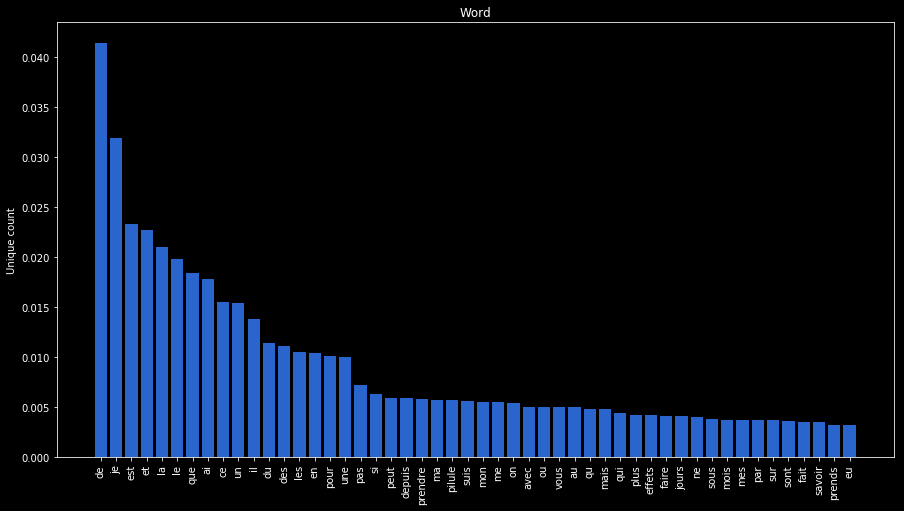

9870


In [17]:
sentences = x[:,1]
sortedVocabulary = vectorizeVocabulary(sentences, verbose=False, density=True)
plotVocabulary(sortedVocabulary)
print(len(sortedVocabulary))

# Distribution des catégories

In [8]:
countCategories = [0] * NUMBER_CATEGORIES

for point in y:
    countCategories[point[1]] += 1

indexedCountCategories = list(zip(list(range(NUMBER_CATEGORIES)), countCategories))

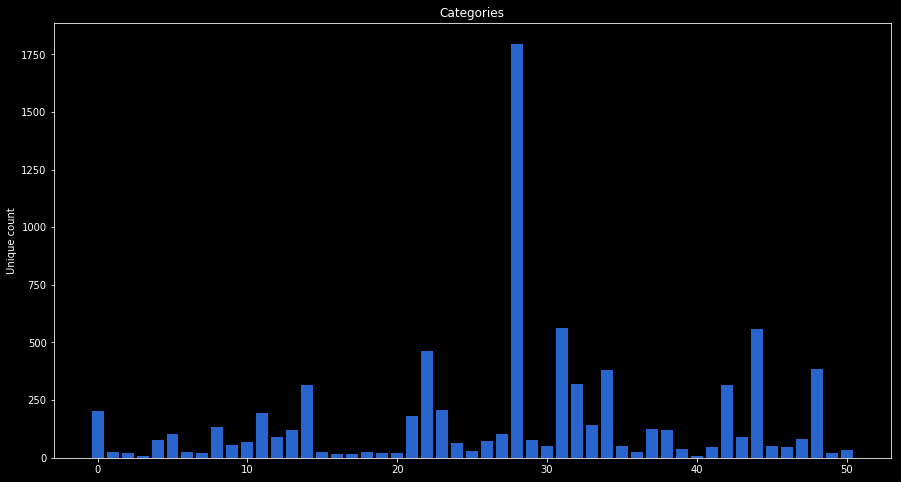

In [9]:
yPosition = np.arange(NUMBER_CATEGORIES)

plt.figure(figsize=(15,8))
plt.bar(yPosition, countCategories, color=colors[0])

plt.ylabel('Unique count')
plt.title('Categories')
axes = plt.gca()
#axes.set_ylim([0,50])
plt.show()

In [10]:
selectedCategories = list(filter(lambda x:  50 < x[1] <= 100, indexedCountCategories))
selectedCategories

[(4, 76),
 (9, 54),
 (10, 68),
 (12, 89),
 (24, 64),
 (26, 72),
 (29, 77),
 (30, 52),
 (43, 91),
 (47, 82)]

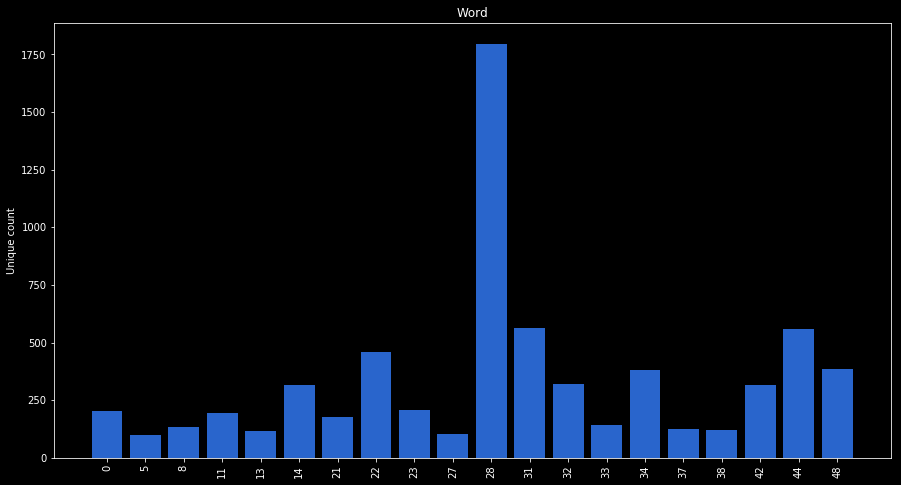

Number of categories with morethan 100 points: 20
Mean of number of points in categories with more than 100 points: 337.0


In [11]:
selectedCategories = list(filter(lambda x: x[1] > 100, indexedCountCategories))

labels = [category[0] for category in selectedCategories]
values = [category[1] for category in selectedCategories]
yPosition = np.arange(len(selectedCategories))

plt.figure(figsize=(15,8))
plt.bar(yPosition, values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('Unique count')
plt.title('Word')
 
plt.show()

print('Number of categories with more'
      'than 100 points: {}'.format(str(len(selectedCategories))))
print('Mean of number of points in categories with more than 100 points: {}'.format(np.mean([cat[1] for cat in selectedCategories])))

# Distribution du vocabulaire par catégorie

countVector.shape: (104, 822)
wordCount.shape: (1, 822)
[['de', 0.046953046953046952], ['je', 0.033300033300033303], ['et', 0.02763902763902764], ['ai', 0.022311022311022312], ['que', 0.02197802197802198]]


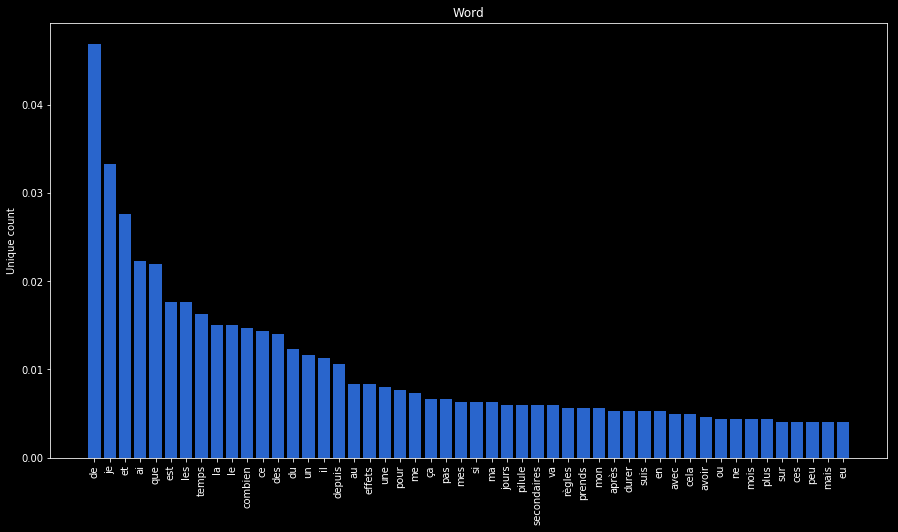

In [12]:
category = 27
selectedSentences = x[y == category][1:]
sortedVocabularyCategory =\
    vectorizeVocabulary(list(map(lambda x: str(x), selectedSentences)),
                        verbose=True, density=True)
plotVocabulary(sortedVocabularyCategory)

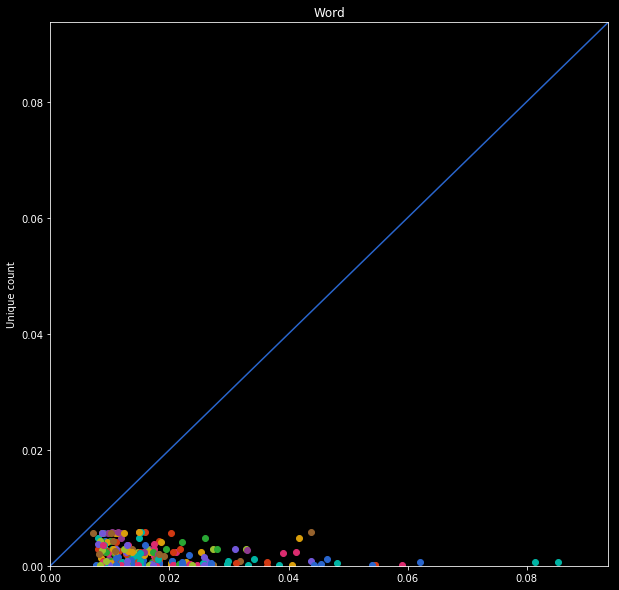

In [13]:
vocabularyDict = dict(sortedVocabulary)
plt.figure(figsize=(10,10))
m = 0
selectedWords = {}

for category in range(NUMBER_CATEGORIES):
    selectedSentences = x[y == category][1:]
    sortedVocabularyCategory = vectorizeVocabulary(list(map(lambda x: str(x),
                                                            selectedSentences)),
                                                   density=True)

    for word in sortedVocabularyCategory[:20]:
        if not word[0] in STOP_WORDS:
            m = max(word[1], m)
            plt.scatter(word[1], vocabularyDict[word[0]],
                        color=colors[category % len(colors)], label=str(category))
            if category in selectedWords:
                selectedWords[category].append([*word, vocabularyDict[word[0]]])
            else:
                selectedWords[category] = [[*word, vocabularyDict[word[0]]]]

plt.plot([0, 1], color=colors[0])
plt.ylim(0, 1.1 * m)
plt.xlim(0, 1.1 * m)
plt.ylabel('Unique count')
plt.title('Word')
plt.show()

# Explore the medicaments names 

In [14]:
MEDICAMENTS = []

with open(os.path.join(dataFolder, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8390
Sample of medicament names:  ['a 313 200  pour cent', 'a 313 50 000 u.i', 'abacavir', 'abacavir/lamivudine', 'abacavir/lamivudine pharma', 'abacavir/lamivudine pharos', 'abamipharm', 'abboticine', 'abelcet', 'abstral']


In [15]:
medicaments_occurences = []
nb_occurences = 0
unique_occurences = []
for xx in tqdm(x):
    occur = []
    for w in xx[1].split():
        w = w.lower()
        if w in MEDICAMENTS:
            occur.append(w)
            nb_occurences +=1
            if w not in unique_occurences:
                unique_occurences.append(w)
    medicaments_occurences.append(occur)
print('{} medicaments occurences in the dataset'.format(nb_occurences))
print('{} unique medicament names occuring in the dataset'.format(len(unique_occurences)))

100%|██████████| 8028/8028 [00:14<00:00, 551.04it/s]

9404 medicaments occurences in the dataset
600 unique medicament names occuring in the dataset


## Length of the sentences 

max length: 701 / min length: 1 / mean length:17.4 / median length 10.0 / 99 percentile:112.0
number of  sentences of length > 100 : 105
number of  sentences of length > 200 : 18


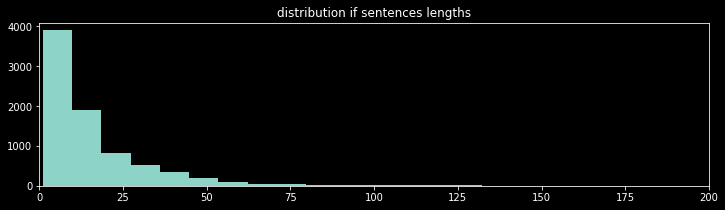

In [45]:
sent_lengths = [len(xx.split()) for xx in x[:,1]]
plt.figure(figsize=(12,3))
plt.hist(sent_lengths, bins = 80)
plt.xlim((0, 200))
plt.title('distribution if sentences lengths')
print('max length: {} / min length: {} / mean length:{} / median length {} / 99 percentile:{}'.format(
    max(sent_lengths), min(sent_lengths), 
    round(np.mean(sent_lengths),1), np.median(sent_lengths), np.percentile(sent_lengths, 99)))
print('number of  sentences of length > 100 : {}'.format(np.sum([1 for e in sent_lengths if e >100])))
print('number of  sentences of length > 200 : {}'.format(np.sum([1 for e in sent_lengths if e >200])))
plt.show()


In [16]:
def selectCat(x, y, cat_index, medicaments_occurences = medicaments_occurences):
    cat_ix = []
    for xx, yy in zip(x, y):
        if yy[1] == cat_index:
            cat_ix.append(xx[0])
    cat_ix = np.array(cat_ix)
    selected_questions = x[cat_ix]
    selected_medics = [medicaments_occurences[ix] for ix in cat_ix]
    return selected_questions, selected_medics

In [17]:
# try to see if there is a correletation between medicament names and the categories
meds_by_category = {}
for cat in set(y[:,1]):
    meds_by_category[cat] = []
    
for yy, meds in zip(y, medicaments_occurences):
    for med in meds:
        if med not in meds_by_category[yy[1]]:
            meds_by_category[yy[1]].append(med)

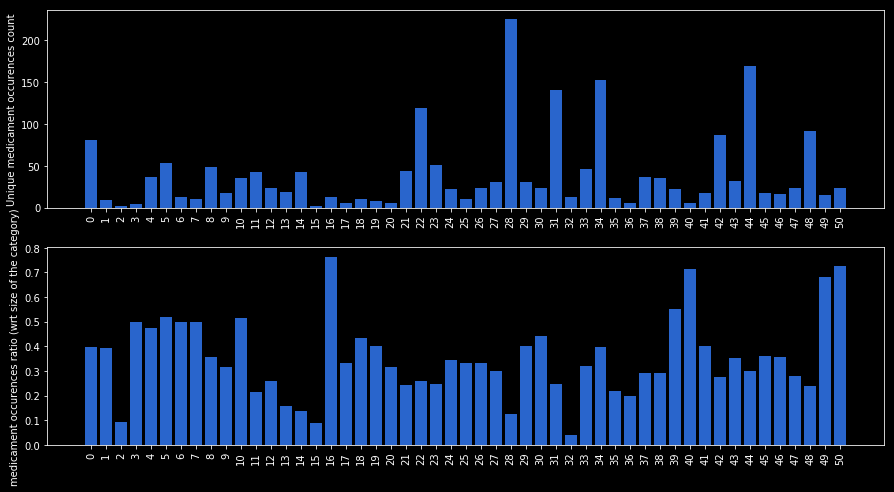

In [18]:
labels = [nb_cat for nb_cat in np.arange(NUMBER_CATEGORIES)]
values = [len(meds_cat) for meds_cat in list(meds_by_category.values())]
ratio_values = [v/l for (v, l) in zip(values, countCategories)]
yPosition = np.arange(NUMBER_CATEGORIES)

plt.figure(figsize=(15,8))
plt.title('Divesity of medicament names in the different categories')
plt.subplot(211)
plt.bar(yPosition, values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('Unique medicament occurences count')

plt.subplot(212)
plt.bar(yPosition, ratio_values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('medicament occurences ratio (wrt size of the category)')

plt.show()

# Explore the variety of questions

In [19]:
cat_index = 46
cat_questions, med_questions = selectCat(x, y, cat_index)
print('There are {} questions in category {}'.format(len(cat_questions), cat_index))
cat_questions[:10]

There are 45 questions in category 46


array([[56,
        'le prix du générique lisinopril 20mg est passé subitement de 12,39€ à 13,25€ , est ce normal?'],
       [75, 'je souhaiterais savoir quel est le prix du vermifuge humain ?'],
       [457,
        'je voudrais commencer une cure de cystine b6. j ai entendu dire qu en france le prix etait de 3 € ?'],
       [484,
        "j'ai arrêté cycléane 20 il y a 4 ans et là j'attends mes règles pour pouvoir la reprendre. je voudrais savoir combien coûtent les 3 plaquettes maintenant ?"],
       [703,
        'obligé de payer mon rivotril 50 euros la bouteille , normal ?'],
       [1003, 'cérazette ? Combien ça coûte ?'],
       [1047,
        'obligé de payer mon rivotril 50 euros la bouteille , normal ?'],
       [1091, 'tarif trinordiol?'],
       [1602, 'Quel est le prix du générique biogaran de mercilon ?'],
       [1718, 'prix cycléane 20 ?']], dtype=object)

### See short questions

In [20]:
min_length = 15
short_questions = []
for xx in x:
    if len(xx[1]) <= min_length:
        short_questions.append((xx[1], y[xx[0],1]))

In [21]:
short_questions[:10]

[('urbanyl?', 22),
 ('deroxat ??', 22),
 ('C quoi neisvac?', 22),
 ('REJET', 14),
 ('neoral', 22),
 ('norset', 22),
 ('optilova 20 ?', 22),
 ('la damiana?', 22),
 ('méningitec ?', 22),
 ('exacyl ??', 22)]

### Extract important vocabulary for each category

In [22]:
def extract_top_k(x, y, k, stop_words = STOP_WORDS):
    best_vocab = []
    nb_cat = len(set(y[:,1]))
    for cat in np.arange(nb_cat):
        questions = selectCat(x, y, cat)[0][:,1]
        cat_vocab = vectorizeVocabulary(corpus=questions)
        cat_best_vocab = []
        for w in cat_vocab:
            if len(cat_best_vocab) < k:
                if w[0] not in stop_words:
                    cat_best_vocab.append(w)           
        best_vocab.append(cat_best_vocab)
    return best_vocab

In [23]:
best_vocab = extract_top_k(x, y, 10)

In [87]:
ix = 11
best_vocab[ix]

[['faire', 102],
 ['dois', 46],
 ['plus', 46],
 ['me', 35],
 ['suis', 34],
 ['jours', 26],
 ['mal', 24],
 ['mois', 22],
 ['pris', 21],
 ['prise', 21]]

In [88]:
questions = selectCat(x, y, ix)[0]
print('{} questions in class {}'.format(len(questions),ix))
print(questions[:20])

195 questions in class 11
[[34
  "je viens de commencer le traitement cystine b6 depuis 3 jours et j'ai des gaz que puis-je faire ?"]
 [38
  "le medecin spécialiste gastro m'a préscrit lansoprazole. mon médecin traitant m'a préscit olmetec 20 mg pour hypertension, et depuis qiue je les prends ensemble une réaction se forme. des petits points rouges très demengeant et ambetant sont apparus sur ma quisse droite. j'ai arreté l'olmetec , mais les points ne sont pas encore partis après 3 jours.. que faire ou prendre ?"]
 [79 'help! dépendance ixprim?']
 [111
  "j'ai utilisé l'elavil, le naxproxen a petites doses pour des problèmes de dos. avec le celebrex c'était beaucoup de spasme dans le haut du dos, entre les côtes. le problème de dos à dégénéré en problèmes d'anxiété et je prends en ce moment du rivotril au soir et au couché et du desyrel aussi au coucheé. toujours ses courbatures, bien sûr elle passe facilement au levée, je crois que c'est les médicaments, mais j'en ai pas la certitude